## Flowers Recognition 

The Oxford Flowers 102 dataset is a collection of 102 flower categories commonly occurring in the United 
Kingdom. Each class consists of between 40 and 258 images. The images have large scale, pose and light 
variations. In addition, there are categories that have large variations within the category and several very 
similar categories. 
The dataset is divided into a training set, a validation set and a test set. The training set and validation set 
each consist of 10 images per class (a total of 1020 images each). The test set consists of the remaining 
6149 images (minimum 20 per class). Some tasks to consider: 
1. Modify some previously published architectures e.g., increase the network depth, reducing their 
parameters,  etc.  Explore  more  advanced  techniques  such  as  deformable  convolution,  dilated 
convolution (dilation>1) or visual prompt tuning for Transformers. 
2. Analyze the results of using fewer training images, i.e., few-shot learning 
3. Use  more  advanced  transformation  techniques  such  as  MixUp  (see  the  original  paper  and  its 
PyTorch implementation here) 
4. Try more advanced loss function such as triplet loss

In [19]:
import platform
# Requires virtual env to be set up first.
if platform.system() == "Darwin":  # macOS
    %pip install -r requirements_mac.txt
else:
    %pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu124
Note: you may need to restart the kernel to use updated packages.


## 1. Environment Setup

This section setups the environment by doing the following:
1. Importing the dependencies
2. Checking if CUDA/mps is available on device running this notebook
3. Setting up data and output folder to store downloaded dataset and outputs
4. Setting up of transforms for data augmentation
5. Downloading of datasets after transforms are initialized
6. Setting up of hyper parameters for training
7. Creation of dataloaders and visualizing data

### 1. Importing the dependencies

In [20]:
# Import necessary libraries
import os
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm 
import pandas as pd

# Torch dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary  # For model architecture visualization

# Custom utility files
import src.data_utils as data_utils
import src.visualization as visualization
import src.model_utils as model_utils

# Sets default seeds to 42 for reproducibility
data_utils.set_seeds()

### 2. Checking if CUDA/mps is available

In [21]:
# Set the device based on availability of MPS (macOS), CUDA, or CPU
device = torch.device("mps" if torch.backends.mps.is_available() else 
                      "cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### 3. Setting up data and output folders to store downloaded dataset and output later on

In [22]:
# Define the data directories to store dataset and outputs
data_dir = "./data"
output_dir = "./output" 
save_dir = output_dir + "/saved_models"  # Directory to save trained models

# Create directories if they do not exist
os.makedirs(data_dir, exist_ok=True)
os.makedirs(output_dir, exist_ok=True)

### 4. Image Transforms and Augmentation
In the training transform, it is normalized to those values instead of (0.5, 0.5, 0.5) for both std and mean as it is common practice and was calculated based on millions of images. So we will try that for now.

Ref: https://stackoverflow.com/questions/58151507/why-pytorch-officially-use-mean-0-485-0-456-0-406-and-std-0-229-0-224-0-2

In [23]:
data_transforms = data_utils.get_data_transforms()
display(data_transforms)

{'train': Compose(
     RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomVerticalFlip(p=0.2)
     RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 ),
 'val_test': Compose(
     Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
     CenterCrop(size=(224, 224))
     ToTensor()
     Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
 )}

### 5. Dataset Downloading
- Load the Oxford Flowers 102 dataset which is split into the following:
  - Training : 10 image per class (1020 images)
  - Validation : 10 image per class (1020 images)
  - Test set : remaining images (6149 images)

In [24]:
# Download the dataset
flowers_dataset = data_utils.load_flowers102_dataset(data_dir)
display(flowers_dataset)

Train set size: 1020
Validation set size: 1020
Test set size: 6149


{'train': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.33), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomVerticalFlip(p=0.2)
                RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.85, 1.15), contrast=(0.85, 1.15), saturation=(0.85, 1.15), hue=(-0.15, 0.15))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset Flowers102
     Number of datapoints: 1020
     Root location: ./data
     split=val
     StandardTransform
 Transform: Compose(
                Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
                CenterCrop(size=(224, 224))
                T

The actual labels were acquired from https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1.
We use this to map the actual label to the flower name for better visualisation rather than reading something as 'Flower 1' or 'Flower 27'

In [25]:
flower_labels = data_utils.get_flower_labels("flower_labels.txt")
# Convert the labels to a pandas DataFrame
flower_labels_df = pd.DataFrame(flower_labels, columns=["Flower Name"])
display(flower_labels_df)

,Flower Name
0,pink primrose
1,hard-leaved pocket orchid
2,canterbury bells
3,sweet pea
4,english marigold
...,...
97,mexican petunia
98,bromelia
99,blanket flower
100,trumpet creeper


### 6. Hyperparameters Setup

In [26]:
# Hyperparameters setup
BATCH_SIZE = 32
NUM_EPOCHS = 25
LEARNING_RATE = 0.001
NUM_CLASSES = 102 # Number of classes in the dataset, Oxford 102 has 102 classes 

### 7. Creation of dataloaders and visualizing data

In [27]:
# Create our dataloaders for batching and iterators
data_loaders = data_utils.create_dataloaders(datasets_dict=flowers_dataset, batch_size=BATCH_SIZE, num_workers=4)

# Store our dataset sizes in a dictionary for easy access
dataset_sizes = {
    'train': len(data_loaders['train'].dataset),
    'val': len(data_loaders['val'].dataset),
    'test': len(data_loaders['test'].dataset)
}
display(dataset_sizes)

{'train': 1020, 'val': 1020, 'test': 6149}

This section visualizes samples from our training dataset, showing the original image, the augmented image as well as an example of the "most augmented" image that has the most "different" feature vector from the original to visualize what a good augmented image would look like. The most augmented image is just an example given our initial transforms.

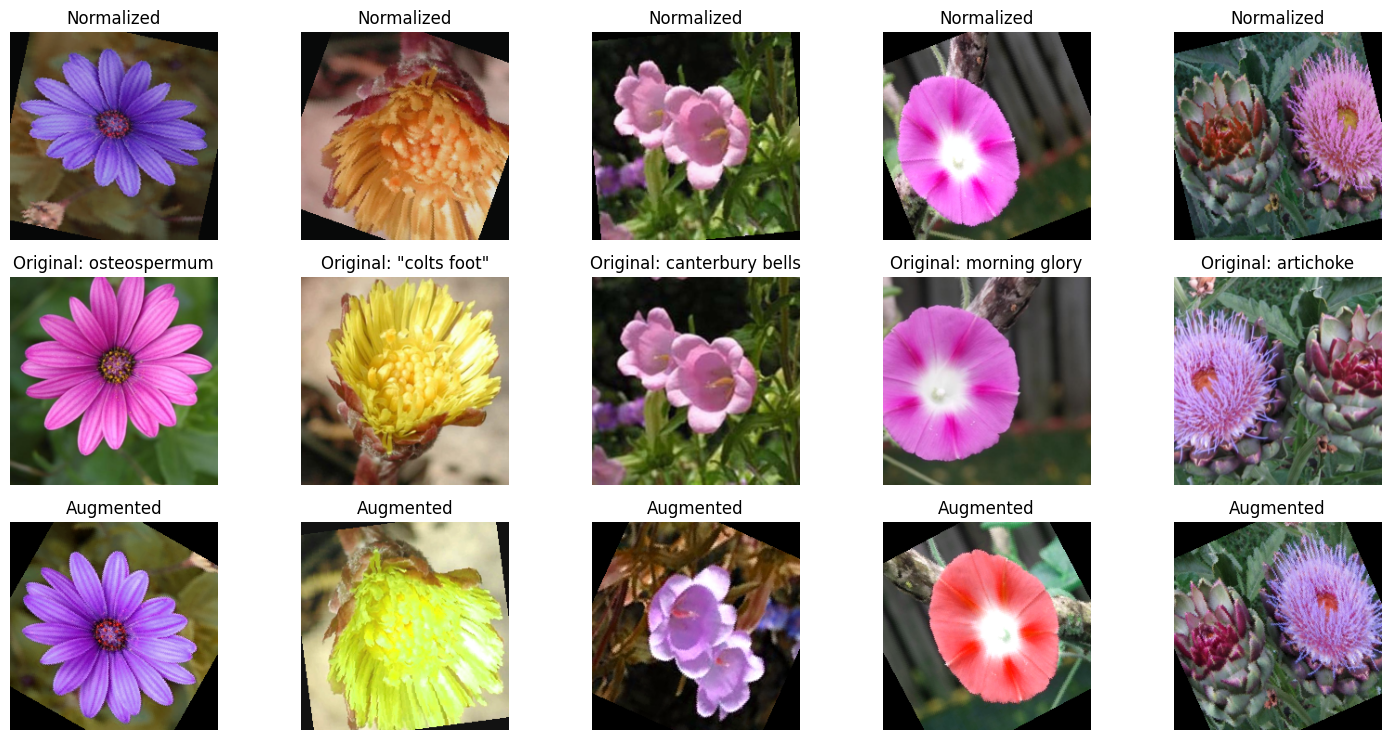

In [28]:
# Visualize a few samples from the training dataset
visualization.visualize_dataset_samples(flowers_dataset['train'], flower_labels, num_samples=5, show_augmented=True)

### 8. Declare Utility Functions

In [29]:
def display_model_architecture(model, device):
    """
    Display model architecture summary including layers and parameters.
    
    Args:
        model (nn.Module): PyTorch model to display
        device (torch.device): Device the model is running on
    
    Returns:
        None: Prints model architecture information
    """
    print(f"\nModel Architecture: {model.__class__.__name__}")
    try:
        summary(model, (3, 224, 224), device=device.type)
    except Exception as e:
        print(f"Could not generate detailed summary: {e}")
        print(model)

def display_model_parameters(model):
    """
    Calculate and display parameter statistics for the model.
    
    Args:
        model (nn.Module): PyTorch model to analyze
    
    Returns:
        tuple: (total_params, trainable_params, non_trainable_params)
    """
    # Calculate parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params

    print(f"\nModel Parameter Information:")
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Non-trainable parameters: {non_trainable_params:,}")
    
    return total_params, trainable_params, non_trainable_params

## Training and evaluating the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.


The `train_model` function is designed to train and evaluate a given neural network model over a specified number of epochs.

### Parameters:

- **model**: The neural network model to be trained.
- **criterion**: The loss function.
- **optimizer**: The optimization algorithm.
- **scheduler**: Adjusts the learning rate based on the number of epochs.
- **num_epochs**: Number of times the model will be trained over the entire dataset (default is 25).

### Process:

1. **Time Tracking**:
    - The start time is recorded to calculate the total training time at the end.

2. **Temporary Directory for Checkpoints**:
    - A temporary directory is created to save the best model parameters during training.

3. **Training Loop**:
    - For each epoch:
        - The model is trained on the training dataset and evaluated on the validation dataset.
        - Depending on the phase (`train` or `val`), the model is set to the appropriate mode using `model.train()` or `model.eval()`.
        - The gradients are zeroed out at the beginning of each batch using `optimizer.zero_grad()`.
        - The model's predictions are compared to the actual labels to compute the loss.
        - If in the training phase, backpropagation is performed and the optimizer updates the model's parameters.
        - Running statistics like loss and accuracy are computed for each epoch.
        - If in the training phase, the learning rate scheduler adjusts the learning rate.
        - The best model (based on validation accuracy) is saved to the temporary directory.

4. **Results**:
    - After all epochs are completed, the total training time is printed.
    - The best validation accuracy achieved during training is also printed.

5. **Load Best Model**:
    - The best model parameters saved during training are loaded back into the model.

6. **Return**:
    - The trained model with the best parameters is returned.

By using this function, one can easily train and evaluate a neural network model, ensuring that the best version of the model (in terms of validation accuracy) is retained.



In [30]:
from tempfile import TemporaryDirectory
def train_model(model, criterion, optimizer, scheduler, dataloaders, dataset_sizes, num_epochs=25):
    """
    Train the model
    
    Args:
        model: The model to train
        criterion: Loss function
        optimizer: Optimizer for updating weights
        scheduler: Learning rate scheduler
        dataloaders: Dictionary containing 'train' and 'val' dataloaders
        dataset_sizes: Dictionary with sizes of 'train' and 'val' datasets
        num_epochs: Number of epochs to train
        
    Returns:
        model: Trained model with best weights
    """
    since = time.time()
    device = next(model.parameters()).device
    
    # Track training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'train_acc': [],
        'val_acc': []
    }

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch + 1}/{num_epochs}')
            print('-' * 20)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in tqdm(dataloaders[phase], desc=phase):
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                
                epoch_loss = running_loss / dataset_sizes[phase]
                if device.type == 'mps':
                    # Mps does not support float64
                    epoch_acc = running_corrects.float() / dataset_sizes[phase]
                else:
                    epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
                
                # Store history
                if phase == 'train':
                    history['train_loss'].append(epoch_loss)
                    history['train_acc'].append(epoch_acc.item())
                else:
                    history['val_loss'].append(epoch_loss)
                    history['val_acc'].append(epoch_acc.item())
                    # Update scheduler based on validation loss
                    scheduler.step(epoch_loss)

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))

    return model, history

In [31]:
def evaluate_model(model, criterion, data_loader):
    """
    Evaluate the model on the test set
    
    Args:
        model: The model to evaluate
        criterion: Loss function
        data_loader: DataLoader for the test dataset
        
    Returns:
        test_loss: The average loss on the test set
        test_acc: The accuracy on the test set
        all_preds: List of all predictions
        all_labels: List of all true labels
    """
    device = next(model.parameters()).device
    model.eval()
    
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    
    # No gradient computation needed for evaluation
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            
            # Statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            
            # Store predictions and labels for further analysis
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate test loss and accuracy
    dataset_size = len(data_loader.dataset)
    test_loss = running_loss / dataset_size
    test_acc = running_corrects.float() / dataset_size
    
    print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
    
    return test_loss, test_acc, all_preds, all_labels

### Training Setup
This section sets up the optimizer, criterion, and scheduler that will be used for the experiments.

We use CrossEntropyLoss as our criterion since we're dealing with multi-class classification. For optimization, we use Adam with an initial learning rate of LEARNING_RATE. Adam typically converges faster than SGD for many deep learning tasks by adaptively adjusting the learning rates of individual parameters.

To improve training dynamics, we implement a ReduceLROnPlateau scheduler, which reduces the learning rate by a factor of 0.1 when the validation loss stops improving for 3 consecutive epochs. This approach helps the model converge more effectively, especially when training reaches a plateau.

In [32]:
# Declare a function for saving model and history so that we do not need to retrain it each time and can load

In [33]:
criterion = nn.CrossEntropyLoss()  # Loss function for multi-class classification

def get_optimizer_and_scheduler(model):
    # Using Adam optimizer
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # Learning rate scheduler - reduce learning rate when validation loss plateaus
    # patience=3: wait for 3 epochs with no improvement before reducing LR
    # factor=0.1: multiply learning rate by 0.1 when reducing
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)
    return optimizer, scheduler

## Model 1: Base CNN Model

In [34]:
# Set up the model, optimizer and scheduler for training and evaluation
from src.models.base_cnn import BaseCNN

# Initialize the model and history as None first
base_cnn = None
history = {}
model_name = "base_cnn"

# Attempt to load from previous
if model_utils.check_model_exists(model_name ="base_cnn", save_dir=save_dir):
    print(f"Loading existing model: {model_name}")
    # Load the pre-trained model and its history
    base_cnn, history = model_utils.load_model_and_history(
        BaseCNN, 
        model_name=model_name, 
        num_classes=NUM_CLASSES, 
        save_dir=save_dir,
        device=device
    )
    
    # Display the architecture and parameters of the loaded model
    display_model_architecture(base_cnn, device)
    display_model_parameters(base_cnn)
    
    print("Model loaded successfully! Skipping training phase.")
else:
    print(f"No existing model found. Initializing and training new model: {model_name}")
    
    # Initialize the model
    base_cnn = BaseCNN(num_classes=NUM_CLASSES)
    base_cnn = base_cnn.to(device)  # Send to GPU if possible
    
    # Show the parameters and architecture of the model
    display_model_architecture(base_cnn, device)
    display_model_parameters(base_cnn)
    
    # Initialize optimizer and scheduler
    optimizer, scheduler = get_optimizer_and_scheduler(base_cnn)
    
    # Train the model
    model, history = train_model(
        model=base_cnn, 
        criterion=criterion, 
        optimizer=optimizer, 
        scheduler=scheduler, 
        dataloaders=data_loaders, 
        dataset_sizes=dataset_sizes, 
        num_epochs=NUM_EPOCHS
    )
    
    # Save the model after training
    model_utils.save_model_and_history(model, history, model_name=model_name, save_dir=save_dir)
    
    print(f"Model trained and saved successfully!")

No existing model found. Initializing and training new model: base_cnn

Model Architecture: BaseCNN
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
       BatchNorm2d-2         [-1, 32, 224, 224]              64
            Conv2d-3         [-1, 64, 224, 224]          18,496
       BatchNorm2d-4         [-1, 64, 224, 224]             128
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
       BatchNorm2d-7        [-1, 128, 112, 112]             256
         MaxPool2d-8          [-1, 128, 56, 56]               0
            Conv2d-9          [-1, 192, 56, 56]         221,376
      BatchNorm2d-10          [-1, 192, 56, 56]             384
           Conv2d-11          [-1, 256, 56, 56]         442,624
      BatchNorm2d-12          [-1, 256, 56, 56]             512
   

train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.6779 Acc: 0.0216


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 4.3952 Acc: 0.0422

Epoch 2/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 4.1243 Acc: 0.0500


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.9415 Acc: 0.0804

Epoch 3/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.9422 Acc: 0.0735


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6466 Acc: 0.1098

Epoch 4/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.8080 Acc: 0.0922


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.7117 Acc: 0.1118

Epoch 5/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.6632 Acc: 0.0990


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6427 Acc: 0.1255

Epoch 6/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5416 Acc: 0.1255


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.4613 Acc: 0.1529

Epoch 7/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.5254 Acc: 0.1353


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.6298 Acc: 0.1431

Epoch 8/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.3966 Acc: 0.1569


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3334 Acc: 0.1843

Epoch 9/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2880 Acc: 0.1814


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3862 Acc: 0.1696

Epoch 10/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2284 Acc: 0.1637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2078 Acc: 0.1980

Epoch 11/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.2407 Acc: 0.1980


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.3887 Acc: 0.1559

Epoch 12/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.1749 Acc: 0.1833


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2613 Acc: 0.1833

Epoch 13/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0959 Acc: 0.2088


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2083 Acc: 0.2147

Epoch 14/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 3.0446 Acc: 0.2216


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.2815 Acc: 0.1892

Epoch 15/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.8420 Acc: 0.2657


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 3.0089 Acc: 0.2275

Epoch 16/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.8011 Acc: 0.2637


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9862 Acc: 0.2422

Epoch 17/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.7403 Acc: 0.2990


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9530 Acc: 0.2490

Epoch 18/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.7445 Acc: 0.2804


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9804 Acc: 0.2422

Epoch 19/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6722 Acc: 0.3039


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9671 Acc: 0.2412

Epoch 20/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6779 Acc: 0.2961


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9350 Acc: 0.2480

Epoch 21/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6942 Acc: 0.2941


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9270 Acc: 0.2559

Epoch 22/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6520 Acc: 0.3137


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9035 Acc: 0.2627

Epoch 23/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6752 Acc: 0.2931


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9081 Acc: 0.2676

Epoch 24/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.6237 Acc: 0.3186


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.8848 Acc: 0.2725

Epoch 25/25
--------------------


train:   0%|          | 0/32 [00:00<?, ?it/s]

train Loss: 2.5898 Acc: 0.3225


val:   0%|          | 0/32 [00:00<?, ?it/s]

val Loss: 2.9186 Acc: 0.2647

Training complete in 6m 44s
Best val Acc: 0.272549
Model saved to ./output/saved_models\base_cnn.pth
Training history saved to ./output/saved_models\base_cnn_history.json
Model trained and saved successfully!


C:\Users\isaac\AppData\Local\Temp\ipykernel_7244\730607927.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


Testing:   0%|          | 0/193 [00:00<?, ?it/s]

Test Loss: 3.0436 Acc: 0.2443
Final Test Accuracy: 0.2443
Final Test Loss: 3.0436


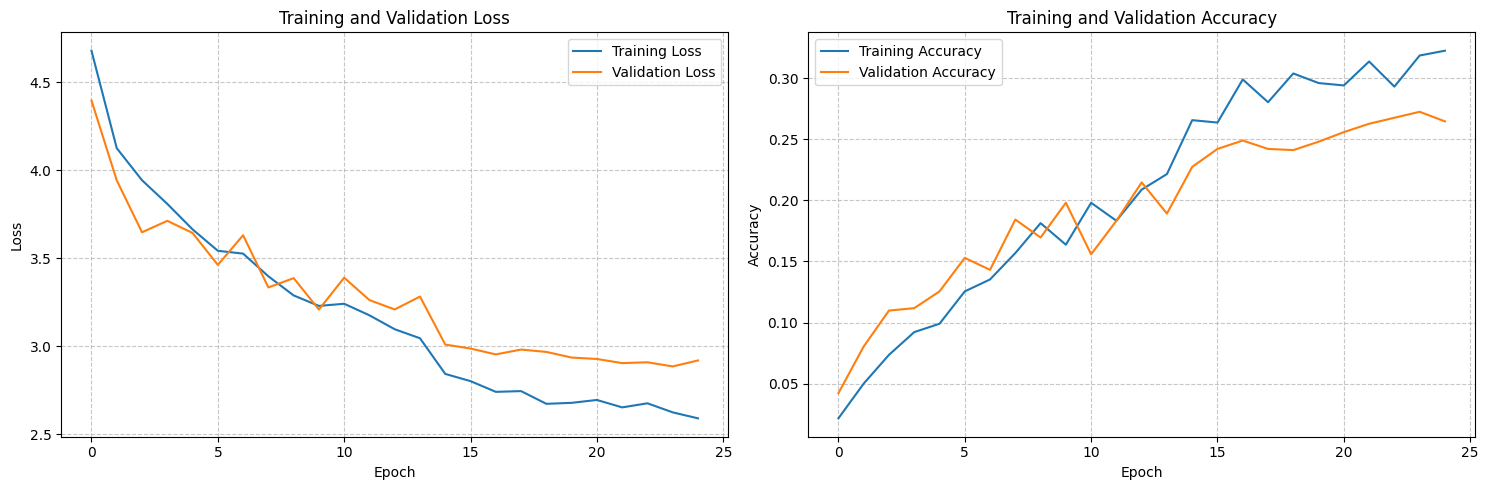

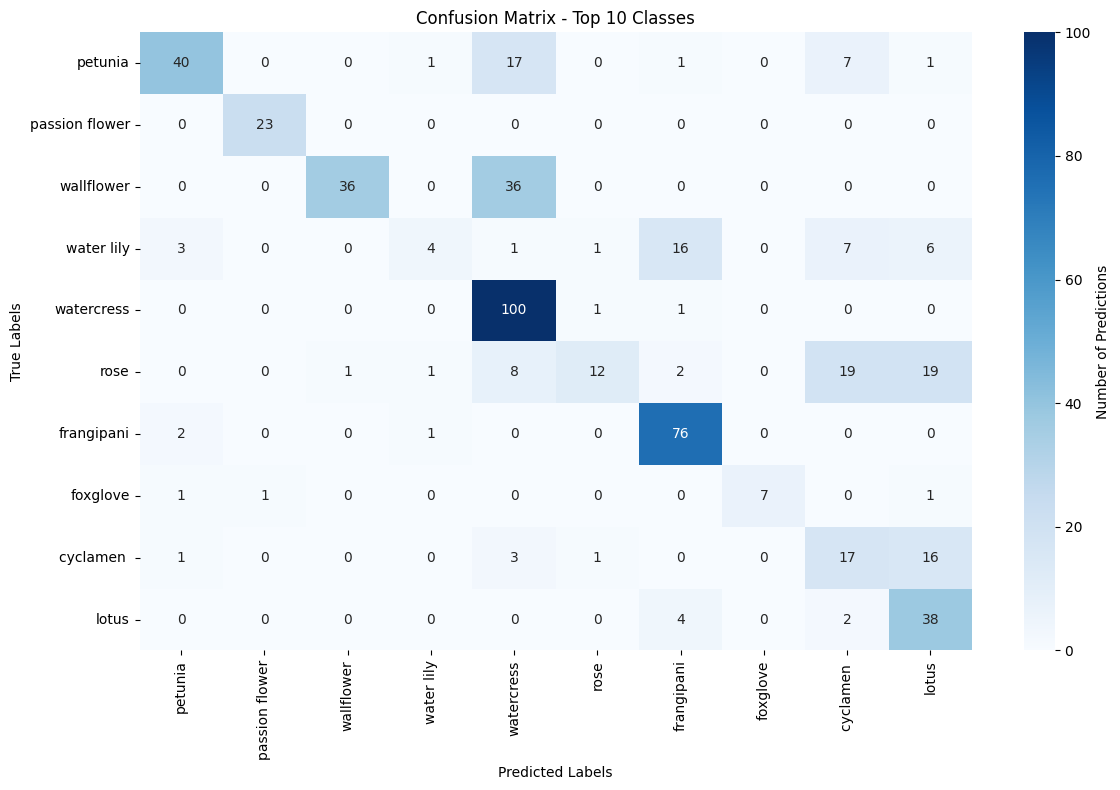

Classification Report - Top 10 Classes:
                precision    recall  f1-score   support

       petunia       0.85      0.60      0.70        67
passion flower       0.96      1.00      0.98        23
    wallflower       0.97      0.50      0.66        72
    water lily       0.57      0.11      0.18        38
    watercress       0.61      0.98      0.75       102
          rose       0.80      0.19      0.31        62
    frangipani       0.76      0.96      0.85        79
      foxglove       1.00      0.70      0.82        10
     cyclamen        0.33      0.45      0.38        38
         lotus       0.47      0.86      0.61        44

      accuracy                           0.66       535
     macro avg       0.73      0.63      0.62       535
  weighted avg       0.72      0.66      0.63       535



In [37]:
# Evaluate the model on the test set
test_loss, test_acc, all_preds, all_labels = evaluate_model(base_cnn, criterion, data_loaders['test'])

# Print final results
print(f"Final Test Accuracy: {test_acc:.4f}")
print(f"Final Test Loss: {test_loss:.4f}")

# Plot training history
visualization.plot_training_history(history)
# Plot confusion matrix
visualization.plot_top_n_confusion_matrix(all_labels, all_preds, flower_labels, top_n=10)

Finding closest images for misclassification 1/5...
Finding closest images for misclassification 2/5...
Finding closest images for misclassification 3/5...
Finding closest images for misclassification 4/5...
Finding closest images for misclassification 5/5...


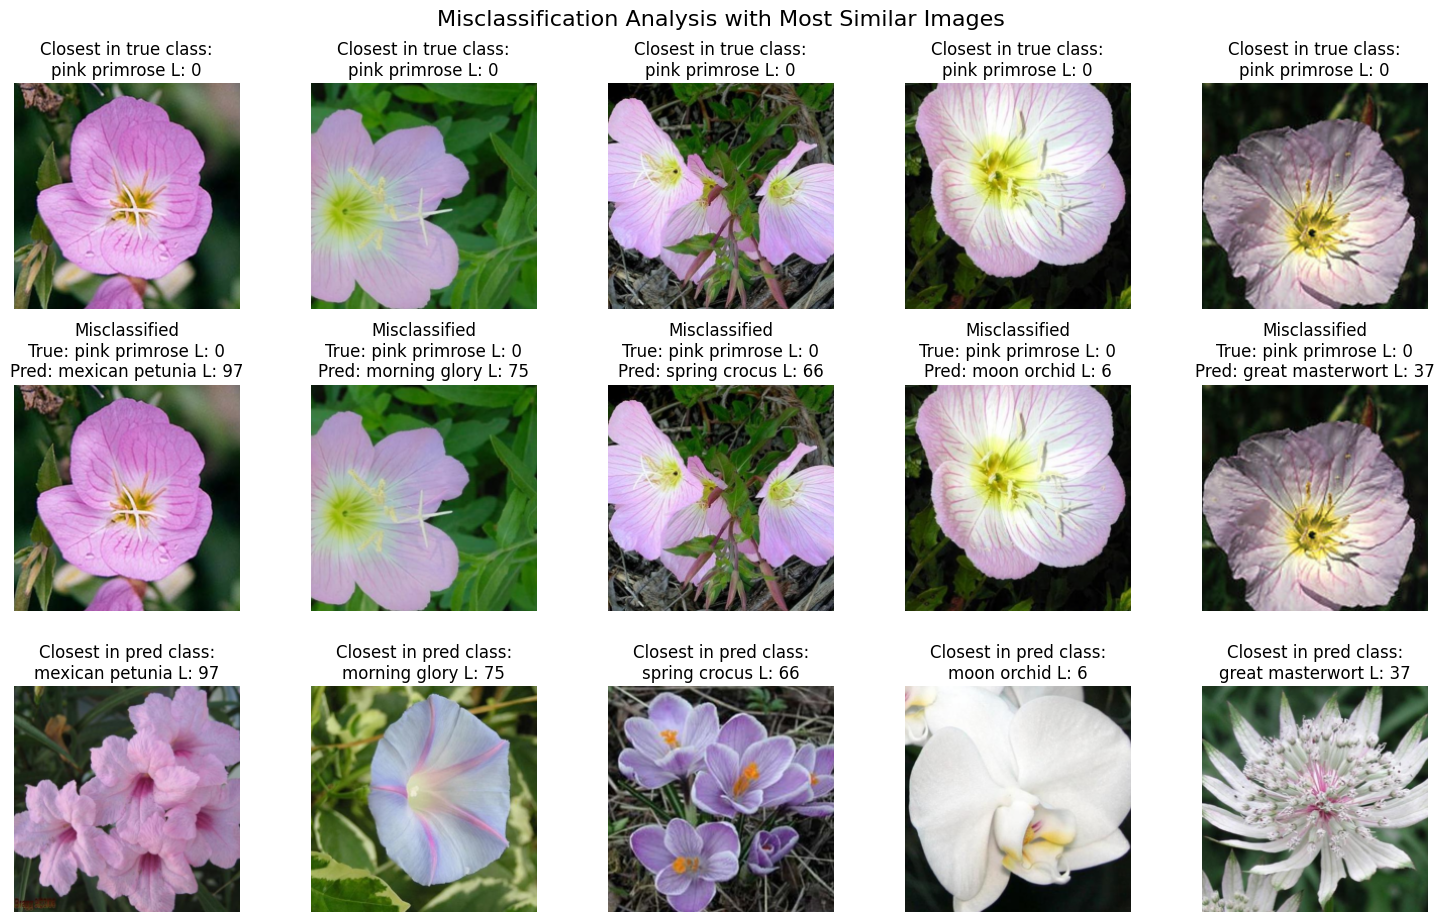

{'unique_true_classes': 1, 'unique_class_pairs': 5, 'total_examples': 5}

In [38]:
visualization.visualize_misclassifications_with_closest_images(base_cnn, data_loaders['test'], flower_labels, flowers_dataset['test'])